### Time-series model

- modèle [Autoformer](https://huggingface.co/blog/autoformer)
- modèle [Time Series Transformer](https://huggingface.co/docs/transformers/model_doc/time_series_transformer)
- modèle [Informer](https://huggingface.co/blog/informer)
- modèle [Sk Forecast](https://huggingface.co/blog/skforecast)

In [95]:
# Import all data visualisation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import ipywidgets as ipy
from IPython.display import Image

sns.set_theme()
sns.set_palette("colorblind")
sns.set_style('whitegrid')
plt.tight_layout()
%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [96]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('data/output_data.csv', parse_dates = ['date'])
df = df.set_index('date')
df = df.asfreq('B')

df = df.sort_index()

start_train = '2017-08-01'
end_train = '2022-09-01'
start_test = '2022-09-01'
end_test = '2023-05-01'
timedelta_test = datetime.strptime(end_test, '%Y-%m-%d') - datetime.strptime(start_test, '%Y-%m-%d')
 
# Split dataset in date between 08-2017 to 08-2022 and testing fom 09-2022 to 04-2023

X_train = df.loc[start_train:end_train]
X_test = df.loc[start_test:end_test]

X_train.shape, X_test.shape
df['Close_BTC'].isna().sum()

0

In [97]:
# Extract all column name starting by 'close'
targets = [col for col in df.columns if col.startswith('Close')]
targets

['Close_BTC',
 'Close_ETH',
 'Close_DOGE',
 'Close_SHIB',
 'Close_DOT',
 'Close_BCH',
 'Close_SOL',
 'Close_ADA',
 'Close_MATIC',
 'Close_BNB',
 'Close_LTC',
 'Close_XRP']

### Preprocessing

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

### Infinites values

In [99]:
def replace_infinities(X):
    return X.replace([np.inf, -np.inf], np.nan)

replace_infinities_transformer = FunctionTransformer(replace_infinities)


### 0 standard deviation

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class RemoveZeroStdColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.zero_std_mask_ = np.std(X, axis=0) != 0
        return self

    def transform(self, X, y=None):
        return X[:, self.zero_std_mask_]

### Outliers

In [101]:
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt

def plot(column):
    if df[column].dtype in ['int64', 'float64']:
        sns.boxplot(x=df[column])
    else:
        sns.countplot(x=df[column])
    plt.show()

interact(plot, column=df.columns.tolist())

interactive(children=(Dropdown(description='column', options=('btc_tweet_count', 'eth_tweet_count', 'bnb_tweet…

<function __main__.plot(column)>

In [102]:
# To write a function to handle outliers

### Missing data

In [103]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

# Get all col containing missing values
na_cols = [col for col in X_train.columns if X_train[col].isna().sum() > 0]
imputer = KNNImputer()

print(len(na_cols))

153


### Numerical data

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [105]:
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f'Numeric columns : {len(numeric_columns)}')

Numeric columns : 200


### No categorical data

#### Preprocessing pipeline 

In [106]:
std = StandardScaler()
pca = PCA(n_components=70)
inf_col = [col for col in X_train.columns if X_train[col].isin([np.inf, -np.inf]).sum() > 0]
print(len(inf_col))
numeric_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(len(numeric_columns))

preprocessor = Pipeline(steps=[
    # ('outlier', outlier_remover),
    ('replace_infinities', replace_infinities_transformer),
    ('imputer', imputer),
    ('remove_zero_std', RemoveZeroStdColumns()),
    ('scaler', std),
    ('pca', pca)
])

0
200


### VARMAX model

#### Test de stationnarité 

In [107]:
from statsmodels.tsa.stattools import adfuller

target = ['Close_BTC', 'Close_ETH']

y_train = X_train[target]
y_test = X_test[target]

X_train = X_train.drop(columns=target)
X_test = X_test.drop(columns=target)

# Join the two series on index
y_adfuller = pd.concat([y_train, y_test], axis=0)

# Test Dickey-Fuller augmenté

for i in target:
    print(i)
    result = adfuller(y_adfuller.loc[:, i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

Close_BTC
ADF Statistic: -1.504435
p-value: 0.531316
Close_ETH
ADF Statistic: -1.662529
p-value: 0.450515


La série n'est pas stationnaire, en particulier à cause de la statistique ADF (-1.5). On va donc devoir différencier la série pour la rendre stationnaire.

In [109]:
# y_train_log = np.log(y_train)
# y_test_log = np.log(y_test)

# y_adfuller = pd.concat([y_train_log, y_test_log], axis=0)

# # Test Dickey-Fuller augmenté
# result = adfuller(y_adfuller)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])


y_train_diff = y_train.diff().dropna()
y_test_diff = y_train.diff().dropna()

y_adfuller = pd.concat([y_train_diff, y_test_diff], axis=0)

for i in target:
    print(i)
    result = adfuller(y_adfuller.loc[:, i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

Close_BTC
ADF Statistic: -8.401444
p-value: 0.000000
Close_ETH
ADF Statistic: -9.186458
p-value: 0.000000


In [124]:
from statsmodels.tsa.statespace.varmax import VARMAX

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert y_train_diff and y_test_diff to DataFrames
y_train_diff = pd.DataFrame(y_train_diff)
y_test_diff = pd.DataFrame(y_test_diff)

# Create a DataFrame with transformed features
columns = ['PC' + str(i+1) for i in range(X_train_transformed.shape[1])]
X_train_df = pd.DataFrame(X_train_transformed, columns=columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_transformed, columns=columns, index=X_test.index)

# Remove first row because diff was used
X_train_df = X_train_df.iloc[1:]
X_test_df = X_test_df.iloc[1:]


# Create VARMAX model with exogenous variables
model = VARMAX(endog=y_train.iloc[1:] , exog=X_train_df, order=(1, 1))
model_fit = model.fit(disp=False)

/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [125]:
# Make prediction
y_pred = model_fit.forecast(steps=len(X_test_df), exog=X_test_df)

/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [126]:
y_pred

,Close_BTC,Close_ETH
2022-09-02,15854.393516,1336.691562
2022-09-05,12571.461680,1081.239189
2022-09-06,13608.008216,1121.301385
2022-09-07,14551.699996,1206.609095
2022-09-08,13757.791729,1116.173306
...,...,...
2023-03-20,4163.763566,15.293276
2023-03-21,705.580836,-178.250140
2023-03-22,623.933800,-203.024984
2023-03-23,206.542863,-220.580572


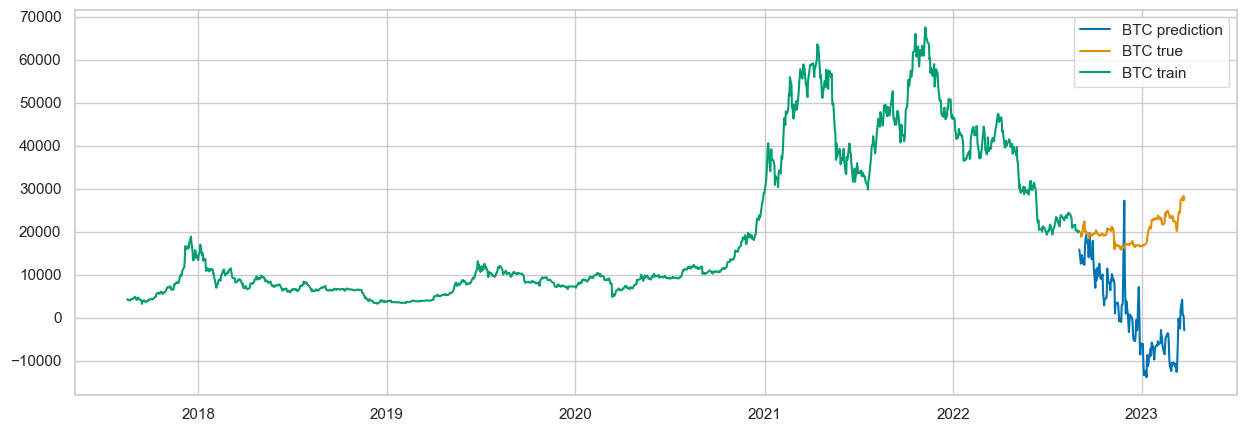

In [127]:
# Plot y_pred, y_test, X_train[target], with correct label for BTC and ETH
plt.figure(figsize=(15, 5))
plt.plot(y_pred['Close_BTC'], label='BTC prediction')
plt.plot(y_test['Close_BTC'], label='BTC true')
plt.plot(y_train['Close_BTC'], label='BTC train')
plt.legend();

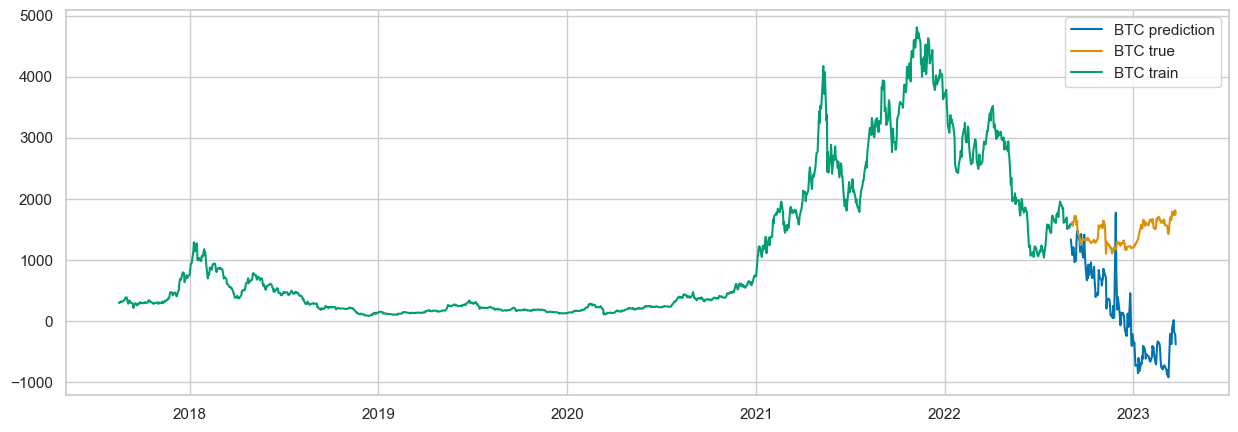

In [128]:
# Plot y_pred, y_test, X_train[target], with correct label for BTC and ETH
plt.figure(figsize=(15, 5))
plt.plot(y_pred['Close_ETH'], label='BTC prediction')
plt.plot(y_test['Close_ETH'], label='BTC true')
plt.plot(y_train['Close_ETH'], label='BTC train')
plt.legend();